In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from chainconsumer import ChainConsumer
#import corner
from scipy import optimize as op

In [117]:
d=2.5
CN=1.
def log_prob(x):
    s=x[0]
    CS=x[1]
    if CS <= 0.001 or CS >= 10.:
        return 100.
    else:
        return 0.5*np.log(CS) + 0.5*s**2/CS + 0.5*(s-d)**2/CN
x0=[1,2]
fmin = op.minimize(log_prob,x0)
print(fmin.x)

[1.9999957  3.99995246]


ValueError: x and y must be the same size

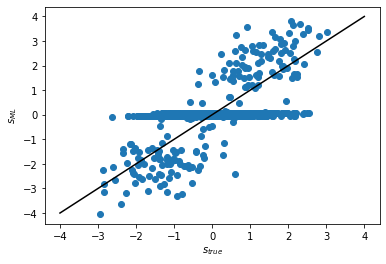

In [124]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(1000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr.append(tmp)
plt.scatter(sarr,xml,label='$C_s=1$')  
plt.plot([-4,4],[-4,4],'-k')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{ML}$')
## Higher C_s
xml=[]
sarr1=[]
csarr1=[]
rat=[]
weiner1=[]
sigma=2.
for i in range(100):
    n=np.random.normal(size=1)
    s=sigma*np.random.normal(size=1)
    sarr1.append(s)
    d=s+n
    weiner1.append(d*4/5.)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr1.append(tmp)
plt.scatter(sarr,xml,label='$C_s=4$') 
plt.axis([-4,4,-4,4])
plt.legend()
plt.savefig('ss.png')


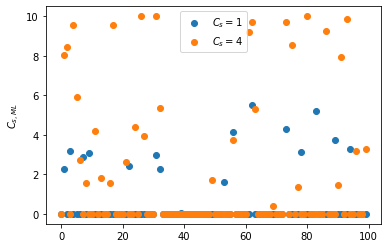

In [46]:
plt.scatter(range(100),csarr,label='$C_s=1$')
plt.scatter(range(100),csarr1,label='$C_s=4$')
plt.ylabel('$C_{s,ML}$')
plt.legend()
plt.savefig('cs.png')
#plt.plot([0,100],[4,4])

In [78]:
### The Weiner filter using the true value of $C_s$ is
## s=d/2 or 4d/5, so that the estimated power spectrum would 
##plt.scatter(rat,csarr)
print(np.mean(csarr))
print(np.mean(rat))

0.5020123987021704
0.4820168149900555


The Weiner filter using the true value of $C_s$ sets $s=d/2$ or $4d/5$ in the two cases above. Let's see how well this does in estimating the signal.

In [130]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    

Text(0, 0.5, '$s_{Weiner}$')

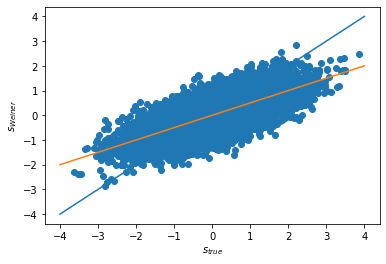

In [133]:
plt.scatter(sarr,weiner,label='$C_s=C_n$')
plt.plot([-4,4],[-4,4])
plt.plot([-4,4],[-2,2])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


It gets the slope wrong, obviously, with mean $\hat s=sC_s/C$. This is the point of maximum likelihood. However, it is interesting to plot the full likelihood.

In [134]:
##low CS
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
CS=.1**2
for i in range(10000):
    n=np.random.normal(size=1)
    s=.1*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d*CS/(1.+CS))
    

Text(0, 0.5, '$s_{Weiner}$')

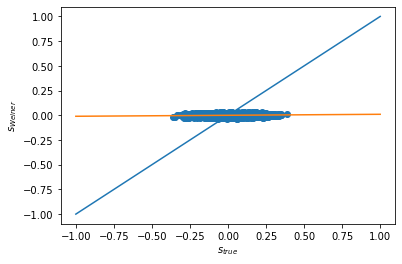

In [136]:
plt.scatter(sarr,weiner,label='$C_s=0.01C_n$')
plt.plot([-1,1],[-1,1])
plt.plot([-1,1],[-.01,.01])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


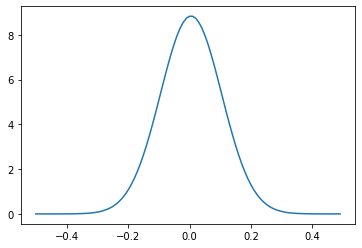

In [140]:
CN=1.
CS=.01
d=.5
def prob(x):
    s=x
    return CS**(-0.5)*np.exp(-0.5*s**2/CS - 0.5*(s-d)**2/CN)
xa=np.arange(-.5,.5,.01)
plt.plot(xa,prob(xa))

The product of 2 gaussians is a gaussian but the peak of the ensuing gaussian is in between $d$ and $0$. In real life the signal can be larger than the data when the noise is negative, but the Weiner filter does not allow for this. So, the maximum likelihood is skewed low.

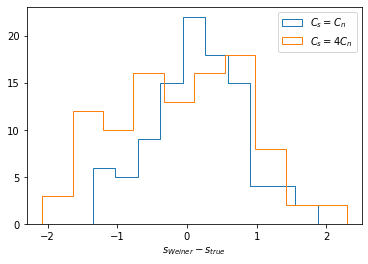

In [105]:
weiner=np.array(weiner)
sarr=np.array(sarr)
weiner1=np.array(weiner1)
sarr1=np.array(sarr1)
plt.hist(weiner-sarr,histtype='step',label='$C_s=C_n$')
plt.hist(weiner1-sarr1,label='$C_s=4C_n$',histtype='step')
plt.legend()
plt.xlabel('$s_{Weiner}-s_{true}$')
plt.savefig('swein.png')

This means that the estimated power spectrum in these two cases would be $d^2 [1/4,16/25]$. We can do a histogram of those predictions.

0.5297018979270384 0.7342915517167761


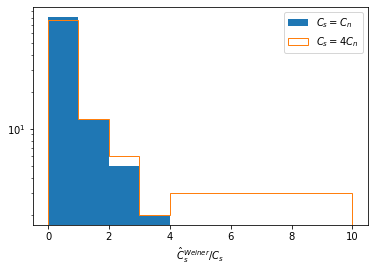

In [112]:
weiner=np.array(weiner)
wbins=[0,1,2,3,4,10]
plt.hist(weiner**2,bins=wbins,label='$C_s=C_n$')
weiner1=np.array(weiner1)
plt.hist(weiner1**2/4,histtype='step',bins=wbins,label='$C_s=4C_n$')
plt.yscale('log')
plt.xlabel('$\hat C_s^{Weiner}/C_s$')
plt.savefig('wpow.png')
plt.legend()
print(np.mean(weiner**2),np.mean(weiner1**2)/4.)

The correct way to estimate the power is to use: $\hat C_s=d^2-C_n$. We can see how well that does here.

1.1188075917081535 0.8973305495574629


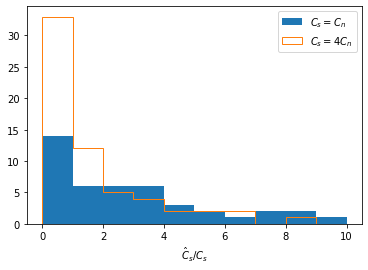

In [115]:
wbins=[0,1,2,3,4,5,6,7,8,9,10]
pow0=weiner**2*4-1.
plt.hist(pow0,bins=wbins,label='$C_s=C_n$')
pow1=((25./16)*weiner1**2-1.)/4
plt.hist(pow1,histtype='step',bins=wbins,label='$C_s=4C_n$')
#plt.yscale('log')
plt.xlabel('$\hat C_s/C_s$')
plt.legend()
plt.savefig('pow.png')
print(np.mean(pow0),np.mean(pow1))

In [3]:
nwalkers = 32
ndim=2
CN=1.
d=1.
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=d + np.random.rand(nwalkers)
p0[:,1]=CN + .2*np.random.rand(nwalkers)
print(np.shape(p0))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[d,CN])


(32, 2)


In [96]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [97]:
sampler.run_mcmc(state,100000);

None


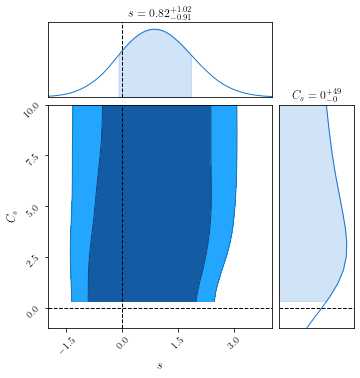

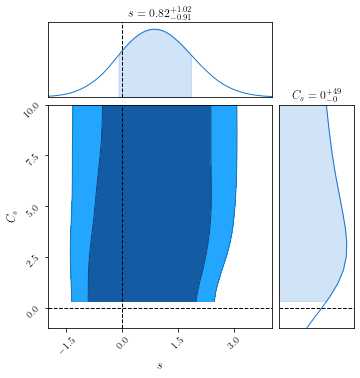

In [100]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s$", "$C_s$"],walkers=32)
print(c.analysis.get_max_posteriors(parameters=["$s$", "$C_s$"]))
#c.add_marker(location=[1,4],marker_style='X',marker_size=40)
c.plotter.plot(filename="l1.png", extents=[(-2,4),(-1,10)],figsize="column",truth=[0,0],legend=None)


In [92]:
estp=.5*(d**2-2. + d*np.sqrt(d**2-4.))
print(estp)
estm=.5*(d**2-2. - d*np.sqrt(d**2-4.))
print(estm)

print(log_prob((np.sqrt(estp),estp), d, CN))
print(log_prob((np.sqrt(estm),estm), d, CN))
print(log_prob((2.38,6.1), d, CN))
print(d**2-CN)

4.0
0.25
-1.3181471805599454
-1.8068528194400546
-1.375639467556846
5.25


In [133]:
np.random.seed(seed=42)
n=np.random.normal(size=2)
s=np.random.normal(size=2)
d=s+n
print(d)

[1.14440269 1.38476556]


In [58]:
CN=1.
def log_2dprob(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return -100
    else:
        return -0.5*np.log(CS**2) - 0.5*np.dot(s,s)/CS - 0.5*np.dot((s-d),s-d)/CN
def log_2dprob_minus(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return 100
    else:
        return 0.5*np.log(CS**2) + 0.5*np.dot(s,s)/CS + 0.5*np.dot((s-d),s-d)/CN


In [182]:
nwalkers = 32
ndim=3
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=np.random.rand(nwalkers)
p0[:,1]=np.random.rand(nwalkers)
p0[:,2]=(1.+.01*np.random.rand(nwalkers))
print(p0[:,2])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_2dprob, args=[d])
state = sampler.run_mcmc(p0, 100)
sampler.reset()

[1.00280935 1.00542696 1.00140924 1.00802197 1.00074551 1.00986887
 1.00772245 1.00198716 1.00005522 1.00815461 1.00706857 1.00729007
 1.0077127  1.00074045 1.00358466 1.00115869 1.00863103 1.00623298
 1.00330898 1.00063558 1.00310982 1.00325183 1.00729606 1.00637557
 1.00887213 1.00472215 1.00119594 1.00713245 1.00760785 1.00561277
 1.00770967 1.00493796]


In [183]:
sampler.run_mcmc(state,200000)

State([[ 3.35853062e+00  2.48791596e+00  5.86741943e+00]
 [ 2.39582628e+00  1.28981547e+00  2.63513523e+00]
 [ 7.44097104e-01  1.25542905e+00  2.29433541e+00]
 [-1.22712798e+00  2.25121847e-01  9.09531895e+00]
 [ 5.60283694e-01  1.41319535e+00  6.28078096e+00]
 [-1.39553351e+00  7.11698922e-01  1.57488414e+00]
 [ 2.97036050e-01  1.38774705e-01  1.26395094e-01]
 [ 2.48696118e+00 -3.24166978e-01  5.11380040e+00]
 [-5.29975450e-01 -3.58720423e-01  5.29420553e+00]
 [-4.08380155e-02  4.11251361e-01  1.31068590e+00]
 [ 4.40944949e-01 -2.24412254e-01  6.25021234e-01]
 [ 3.96230802e-01  4.87225208e-01  3.33796528e+00]
 [ 1.19404224e+00  1.47897187e+00  7.54433587e+00]
 [ 4.97111793e-01  2.22713067e+00  2.48105284e+00]
 [ 1.28098319e+00  6.28312478e-01  5.85261286e+00]
 [ 9.54488952e-01  6.69067239e-01  9.93746150e+00]
 [ 2.05202186e-01  8.96009293e-01  7.95814953e+00]
 [ 9.85860306e-01  6.94313059e-01  4.17407700e+00]
 [ 6.19024716e-01 -1.80983187e-02  9.13892467e-01]
 [ 7.05525552e-01  9.6919

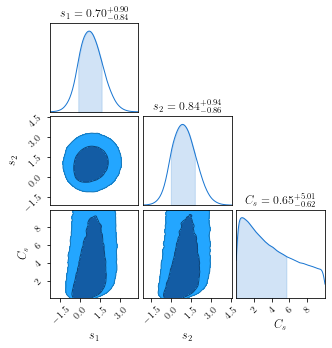

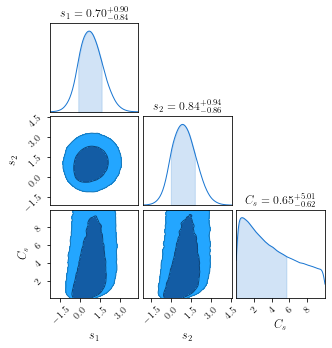

In [187]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s_1$", "$s_2$","$C_s$"])
maxp=[d[0]/2.,d[1]/2.,1.]
c.plotter.plot(filename="3d.png")#,truth=maxp)#,figsize="column",truth=[0,0],legend=None)


In [60]:
print(d)
bard=0.5*np.dot(d,d)
print(bard)
#estp=.5*(bard**2-2. + bard*np.sqrt(bard**2-4.))
#print(estp)
#estm=.5*(bard**2-2. - bard*np.sqrt(bard**2-4.))
#print(estm)

print(log_2dprob([0.,0.,.011], d))
print(log_2dprob([0.7,0.84,.65], d))
#print(log_prob((np.sqrt(estm),estm), d, CN))
#print(log_prob((2.38,6.1), d, CN))


[2.36109278]
2.787379554801199
-1.0648991034186315
-3.0253856220130206


In [77]:
x0=[.1,.1,.5]
fmin = op.minimize((log_2dprob_minus),x0,args=d)#,method='Powell')
print(fmin)

      fun: -0.5144597248001181
 hess_inv: array([[4.17161790e-02, 2.41373667e-01, 1.74189249e-03],
       [2.41373667e-01, 1.44311916e+00, 1.03876928e-02],
       [1.74189249e-03, 1.03876928e-02, 7.47887401e-05]])
      jac: array([   154.79857302,    185.89691752, -20538.55127841])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 381
      nit: 15
     njev: 93
   status: 2
  success: False
        x: array([0.01650379, 0.01976951, 0.00010502])


In [67]:
print(log_2dprob_minus([1.80800108, 1.80799628, 3.26890828],d))
print(log_2dprob_minus([0.1,0.1,.011],d))

2.4903541458930247
1.5117714567706786
